##IMPORTING MODULES

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, GlobalMaxPooling1D, MaxPooling1D, Embedding, Dropout, Activation, SpatialDropout1D, Bidirectional, GRU, LSTM
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.2.0


##LOADING THE DATA

In [2]:
train_data = pd.read_csv('Original_data.csv')
train_data.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


##DROPING UNNECESSARY COLUMNS AND CLEANING OUR TEXTS

In [3]:
import re

train_data_final = train_data.drop(['tweet_id', 'author'], axis = 1)
train_data_final['content'] = [' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split()) for sentence in train_data_final['content'].values.tolist()]
train_data_final.head()

,sentiment,content
0,empty,i know i was listenin to bad habit earlier and...
1,sadness,Layin n bed with a headache ughhhh waitin on y...
2,sadness,Funeral ceremony gloomy friday
3,enthusiasm,wants to hang out with friends SOON
4,neutral,We want to trade with someone who has Houston ...


##EXAMPLE OF DATA

In [4]:
train_sentences = train_data_final['content'].values
value = 1
print(f"Train sentence : {train_sentences.tolist()[value]}")
print(f"Label : {train_data['sentiment'].values[value]}")

Train sentence : Layin n bed with a headache ughhhh waitin on your call
Label : sadness


##OPPOSITE SENTIMENTS

In [5]:
train_data_final['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [69]:
#happiness vs sadness
happiness_df = train_data_final.loc[train_data_final['sentiment']=="happiness"]
worry_df = train_data_final.loc[train_data_final['sentiment']=="worry"]
happiness_worry_df = pd.concat([happiness_df, worry_df])
happiness_worry_df.head(3)

,sentiment,content
40,happiness,mmm much better day so far it s still quite ea...
69,happiness,So great to see Oin amp Cynthia So happy Dinne...
77,happiness,dude that is my favorite sandwich place ever u...


In [70]:
happiness_worry_df['sentiment'] = happiness_worry_df['sentiment'].replace(['happiness'],1)
happiness_worry_df['sentiment'] = happiness_worry_df['sentiment'].replace(['worry'],0)

happiness_worry_df = happiness_worry_df.sample(frac = 1) 
happiness_worry_df

,sentiment,content
10778,0,that s a whole lot of rainstorm goin on Maybe ...
16504,0,i cant spell
36278,1,My day was good Spent the day catching up on s...
18405,0,did not understand anything you said
19017,0,I m nervous I hope I get in this could be a co...
...,...,...
5847,0,IT WAS JAM ALL OVER THE ISLAND Till I m havin ...
25782,1,Will do promise thanks
21055,1,I know how you feel On the bright side you re ...
14747,0,ha im so glad it stopped raining my umbrella b...


In [71]:
y_train_val = happiness_worry_df['sentiment'].values
y_train_val

array([0, 0, 1, ..., 1, 0, 1])

##TOKENIZING for hap_sad

In [72]:
sentences = train_sentences.tolist()
sentences_len = []
for sentence in sentences:
  sentences_len.append(len(sentence.split()))

In [73]:
max_features = 50000
max_text_length = max(sentences_len)+1
embedding_dims = 50

In [74]:
tokenizer = text.Tokenizer(max_features)
tokenizer.fit_on_texts(train_sentences.tolist())
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'to': 2, 'the': 3, 'a': 4, 'my': 5, 'you': 6, 'it': 7, 'and': 8, 'is': 9, 'in': 10, 'for': 11, 's': 12, 't': 13, 'of': 14, 'that': 15, 'on': 16, 'me': 17, 'have': 18, 'so': 19, 'but': 20, 'm': 21, 'just': 22, 'day': 23, 'with': 24, 'be': 25, 'at': 26, 'was': 27, 'not': 28, 'all': 29, 'good': 30, 'this': 31, 'now': 32, 'can': 33, 'out': 34, 'up': 35, 'get': 36, 'like': 37, 'no': 38, 'are': 39, 'quot': 40, 'go': 41, 'do': 42, 'your': 43, 'today': 44, 'love': 45, 'work': 46, 'too': 47, 'got': 48, 'going': 49, 'we': 50, 'happy': 51, 'what': 52, 'lol': 53, 'from': 54, 'one': 55, 'time': 56, 'u': 57, 'know': 58, 'back': 59, 'will': 60, 'there': 61, 'really': 62, 'im': 63, 'don': 64, 'about': 65, 'am': 66, 'see': 67, 'its': 68, 'amp': 69, 'had': 70, 'they': 71, 'night': 72, 'some': 73, 'if': 74, 'new': 75, 'home': 76, 'how': 77, 'think': 78, 'well': 79, '2': 80, 'thanks': 81, 'when': 82, 'want': 83, 'as': 84, 'oh': 85, 'll': 86, 'still': 87, 'off': 88, 'he': 89, 'much': 90, 'here': 9

In [75]:
tokenized = tokenizer.texts_to_sequences(happiness_worry_df['content'].values.tolist())
x_train_val = sequence.pad_sequences(tokenized, maxlen = max_text_length)
print(x_train_val.shape)
print(y_train_val.shape)

(13668, 41)
(13668,)


##BUILDING OUR MODEL

In [76]:
filters = 64
kernel_size = 3
hidden_dims = 128

In [77]:
model = Sequential()

model.add(Embedding(max_features,embedding_dims))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1, activation='sigmoid'))
model.summary()
print('\n\n\n')
print('__Model Built__')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          2500000   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          9664      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

##COMPILING OUR MODEL

In [78]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

##Splitting the DATASET for training and validation


In [79]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y_train_val,
                                                  test_size = 0.20)


##Training and Evaluating

In [80]:
batch_size = 32; epochs = 3
history = model.fit(x_train,
                  y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (x_val, y_val))

Epoch 1/3
342/342 [==============================] - 10s 30ms/step - loss: 0.5974 - accuracy: 0.6751 - val_loss: 0.5100 - val_accuracy: 0.7535
Epoch 2/3
342/342 [==============================] - 10s 30ms/step - loss: 0.4306 - accuracy: 0.8069 - val_loss: 0.5141 - val_accuracy: 0.7659
Epoch 3/3
342/342 [==============================] - 10s 30ms/step - loss: 0.2969 - accuracy: 0.8788 - val_loss: 0.5437 - val_accuracy: 0.7538


##Plotting


In [81]:
%matplotlib inline
import matplotlib.pyplot as plt


#For Training
losses_train = history.history['loss']
accuracy_train = history.history['accuracy']

#For Validation
losses_test = history.history['val_loss']
accuracy_test = history.history['val_accuracy']

epochs_num = [d for d in range(1,epochs+1)]

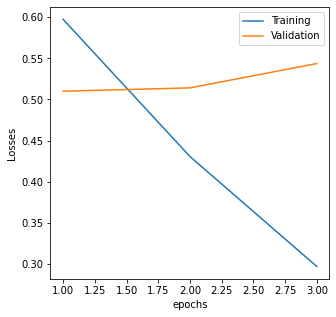

In [82]:
plt.figure(figsize=(5, 5))
plt.xlabel('epochs'); plt.ylabel('Losses')
plt.plot(epochs_num, losses_train, label = 'Training')
plt.plot(epochs_num, losses_test, label = 'Validation' )
plt.legend()
plt.show()

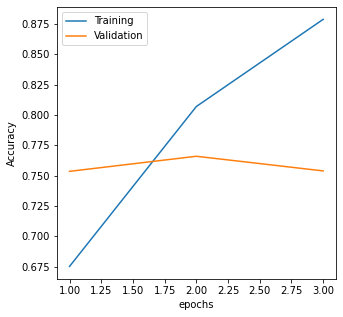

In [83]:
plt.figure(figsize=(5, 5))
plt.xlabel('epochs'); plt.ylabel('Accuracy')
plt.plot(epochs_num, accuracy_train, label = 'Training')
plt.plot(epochs_num, accuracy_test, label = 'Validation' )
plt.legend()
plt.show()

##Testing

In [84]:
with open('EmtionCheck.demo1.txt', 'r') as file:
  lines = file.readlines()
lines  

["Those who have died before their time, i have heard that they become stars. I am afraid, i won't be able to find you among thousands of them there.\n",
 "I don't know for how long i have craved your presence and how many times my heart is broken in your absence.I don't believe in your god anymore, and one fine day, i'll break his heart too."]

In [85]:
preds = []
for line in lines:
  x_test_tokenized = tokenizer.texts_to_sequences([line])
  x_testing = sequence.pad_sequences(x_test_tokenized,
                                    maxlen = max_text_length)
  y_testing = model.predict(x_testing)
  preds.append(y_testing)  


In [86]:
preds = list(map(np.argmax, preds))
preds

[0, 0]

In [90]:
sentiments = [ 'worry', 'happiness']

In [91]:
pred_senti = []
for pred in range(len(preds)):
  pred_senti.append(sentiments[preds[pred]])

In [92]:
ans = {'Text':lines, "predictions":pred_senti}
result = pd.DataFrame(ans)
result.head()

,Text,predictions
0,"Those who have died before their time, i have ...",worry
1,I don't know for how long i have craved your p...,worry


In [93]:
model.save_weights('happiness_worry_weights.h5')

In [94]:
fun_boredommodel_json = model.to_json()
with open("arch_happiness_worry_model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

